This example demonstrates the MUSE reconstruction.

Author:

* Zhengguo Tan <zhengguo.tan@gmail.com>

In [2]:
import h5py
import os
import torch

import matplotlib.pyplot as plt
import numpy as np
from sigpy.mri import retro, sms

import torch.nn as nn
import torch.optim as optim

from deepdwi.models import mri

DIR = os.getcwd()

DAT_DIR = DIR.rsplit('/', 1)[0] + '/data'
print('> data directory: ', DAT_DIR)

# Switch on GPU if your GPU has more than 4 GB memory
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

> data directory:  /home/zhengguo/Softwares/DeepDWI/data


### load data from Zenodo

In [3]:
file_list = ['0.5x0.5x2.0mm_R3x2_coil_pat.h5',
             '0.5x0.5x2.0mm_R3x2_kdat_slice_000_pat.h5',
             '0.5x0.5x2.0mm_R3x2_phase_slice_000_pat.h5',
             '0.5x0.5x2.0mm_R3x2_MUSE_slice_000_pat.h5',
             'md5sum.txt']

for f in file_list:

    if os.path.exists(DAT_DIR + '/' + f):
        print(f'The file {f} exists.')
    else:
        os.system('wget -P ' + DAT_DIR + ' -q https://zenodo.org/record/10474402/files/' + f)

The file 0.5x0.5x2.0mm_R3x2_coil_pat.h5 exists.
The file 0.5x0.5x2.0mm_R3x2_kdat_slice_000_pat.h5 exists.
The file 0.5x0.5x2.0mm_R3x2_phase_slice_000_pat.h5 exists.
The file 0.5x0.5x2.0mm_R3x2_MUSE_slice_000_pat.h5 exists.
The file md5sum.txt exists.


In [4]:
f = h5py.File(DAT_DIR + '/0.5x0.5x2.0mm_R3x2_kdat_slice_000_pat.h5', 'r')
kdat = f['kdat'][:]
MB = f['MB'][()]
N_slices = f['Slices'][()]
N_segments = f['Segments'][()]
N_Accel_PE = f['Accel_PE'][()]
f.close()

kdat = np.squeeze(kdat)  # 4 dim
kdat = np.swapaxes(kdat, -2, -3)

# # split kdat into shots
N_diff = kdat.shape[-4]
kdat_prep = []
for d in range(N_diff):
    k = retro.split_shots(kdat[d, ...], shots=N_segments)
    kdat_prep.append(k)

kdat_prep = np.array(kdat_prep)
kdat_prep = kdat_prep[..., None, :, :]  # 6 dim

print(' > kdat shape: ', kdat_prep.shape)


# coil
f = h5py.File(DAT_DIR + '/0.5x0.5x2.0mm_R3x2_coil_pat.h5', 'r')
coil = f['coil'][:]
f.close()

print(' > coil shape: ', coil.shape)

N_coil, N_z, N_y, N_x = coil.shape


# shot phase
f = h5py.File(DAT_DIR + '/0.5x0.5x2.0mm_R3x2_phase_slice_000_pat.h5', 'r')
shot_phase = f['phase'][:]
f.close()

print(' > shot phase shape: ', shot_phase.shape)

 > kdat shape:  (4, 5, 32, 1, 440, 440)
 > coil shape:  (32, 2, 440, 440)
 > shot phase shape:  (4, 5, 1, 2, 440, 440)


### calculate multi-band phase shift

In [5]:
yshift = []
for b in range(MB):
    yshift.append(b / N_Accel_PE)

sms_phase = sms.get_sms_phase_shift([MB, N_y, N_x], MB=MB, yshift=yshift)

 > sms: yshift  [0.0, 0.3333333333333333]


### reconstruction

In [6]:
coil_tensor = torch.from_numpy(coil).to(device).type(torch.complex64)
kdat_tensor = torch.from_numpy(kdat_prep).to(device).type(torch.complex64)
shot_phase_tensor = torch.from_numpy(shot_phase).to(device).type(torch.complex64)
sms_phase_tensor = torch.from_numpy(sms_phase).to(device).type(torch.complex64)

DWI = []
for n in range(N_diff):

    print('> Diffusion Encoding #', n)

    shot_phase_n = shot_phase_tensor[[n], ...]
    kdat_prep_n = kdat_tensor[[n], ...]

    S = mri.Sense(coil_tensor, kdat_prep_n,
                  phase_echo=torch.conj(shot_phase_n),
                  combine_echo=True,
                  phase_slice=sms_phase_tensor)

    print('> S ishape: ', S.ishape)
    print('> S oshape: ', S.oshape)

    x = torch.zeros(S.ishape, dtype=torch.complex64,
                    requires_grad=True).to(device)

    print('> x device: ', x.device)

    lossf = nn.MSELoss(reduction='sum')
    optimizer = optim.SGD([x], lr=0.1)

    for epoch in range(50):
        fwd = S(x)
        res = lossf(torch.view_as_real(fwd), torch.view_as_real(S.y))

        optimizer.zero_grad()
        res.backward()
        optimizer.step()

        print('> epoch %3d loss %.12f'%(epoch, res.item()))

    DWI.append(x.cpu().detach().numpy())

DWI = np.array(DWI)
DWI = np.squeeze(DWI)
DWI_s1 = DWI[..., 1, :, :]

print(DWI.shape)

> Diffusion Encoding # 0
> S ishape:  [1, 1, 1, 2, 440, 440]
> S oshape:  torch.Size([1, 5, 32, 1, 440, 440])
> x device:  cpu
> epoch   0 loss 0.001084456570
> epoch   1 loss 0.000970523688
> epoch   2 loss 0.000874228193
> epoch   3 loss 0.000792584149
> epoch   4 loss 0.000723149744
> epoch   5 loss 0.000663921353
> epoch   6 loss 0.000613250188
> epoch   7 loss 0.000569774711
> epoch   8 loss 0.000532367616
> epoch   9 loss 0.000500092690
> epoch  10 loss 0.000472170010
> epoch  11 loss 0.000447948463
> epoch  12 loss 0.000426882558
> epoch  13 loss 0.000408514461
> epoch  14 loss 0.000392458634
> epoch  15 loss 0.000378389610
> epoch  16 loss 0.000366032124
> epoch  17 loss 0.000355152704
> epoch  18 loss 0.000345552689
> epoch  19 loss 0.000337062869
> epoch  20 loss 0.000329538656
> epoch  21 loss 0.000322856096
> epoch  22 loss 0.000316908961
> epoch  23 loss 0.000311605807
> epoch  24 loss 0.000306867645
> epoch  25 loss 0.000302626431
> epoch  26 loss 0.000298823026
> epoch  

### display results

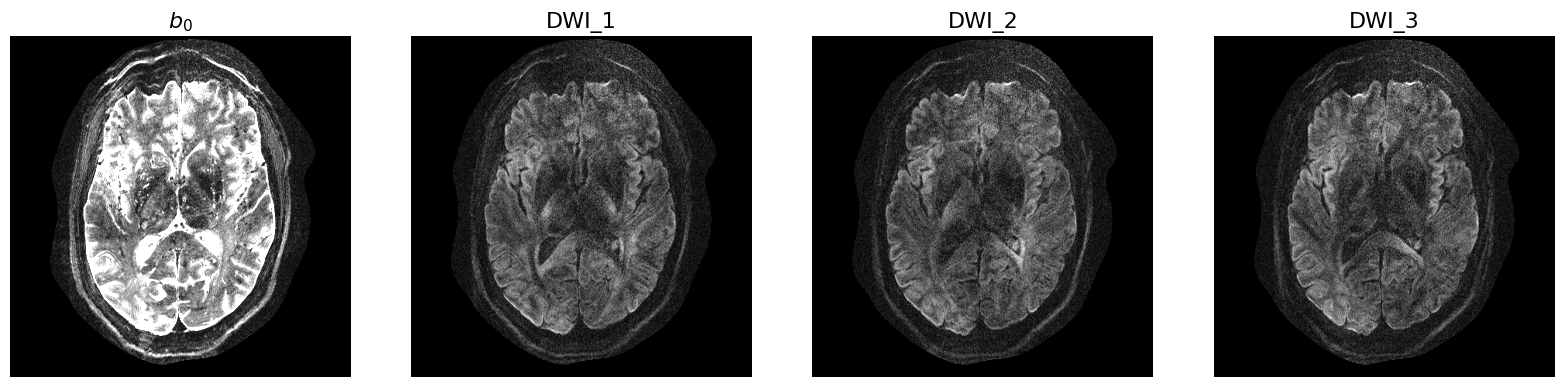

In [20]:
fontsize = 16

vmax = np.amax(abs(DWI_s1)) * 0.15

fig, ax = plt.subplots(1, N_diff, figsize=(N_diff*4 + 0.2, 4))
fig.tight_layout()

for b in range(N_diff):
    ax[b].imshow(abs(np.flip(DWI_s1[b], axis=(-2, -1))), cmap='gray', vmax=vmax)
    ax[b].set_axis_off()
    if b == 0:
        ax[b].set_title('$b_0$', fontsize=fontsize)
    else:
        ax[b].set_title('DWI_' + str(b), fontsize=fontsize)

plt.show()